In [ ]:
# 1) 한 번만: 압축 풀기
!tar xzf EnglishFnt.tgz -C sample_data/

In [ ]:
!pip install "protobuf==3.20.3" tflite-support

In [ ]:
 # 1. EnglishFnt dataset에서 D,N,E 데이터셋 구축

import os
from pathlib import Path
from PIL import Image
import shutil
import random

# 원본 폰트 이미지 경로
FNT_BASE = Path("sample_data/English/Fnt")
OUT_BASE = Path("dataset")
CLASS_MAP = {'Sample014': 'D', 'Sample024': 'N', 'Sample015': 'E'}

# dataset/D, dataset/N, dataset/E 폴더 생성 및 초기화
for c in ['D', 'N', 'E']:
    d = OUT_BASE / c
    if d.exists():
        shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

# 클래스별로 파일 복사 (최대 2000장씩 샘플)
for sample, label in CLASS_MAP.items():
    src = FNT_BASE / sample
    dst = OUT_BASE / label
    files = list(src.glob("*.png"))
    random.shuffle(files)
    for i, f in enumerate(files[:2000]):
        img = Image.open(f).convert("L").resize((32,32))
        img.save(dst / f"{label}_{i:04d}.png")

print("EnglishFnt → dataset/D,N,E 자동 구축 완료")


# 2. Keras 데이터셋 로드 및 증강
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE    = (32, 32)
BATCH_SIZE  = 64
EPOCHS      = 20
TFLITE_PATH = "dne_classifier.tflite"
CLASS_NAMES = ["D", "N", "E"]
VALID_SPLIT = 0.2 #검증데이터 비율
SEED        = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    labels="inferred",
    label_mode="categorical", #one-hot encoding
    class_names=CLASS_NAMES,
    color_mode="grayscale", #흑백
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=VALID_SPLIT,
    subset="training",
    seed=SEED
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=VALID_SPLIT,
    subset="validation",
    seed=SEED
)

normalization = layers.Rescaling(1.0 / 255) #정규화
data_augmentation = tf.keras.Sequential([
    layers.RandomBrightness(0.2), #밝기
    layers.RandomContrast(0.2), #대비
    layers.RandomRotation(0.1), #회전
])

def preprocess_train(x, y):
    x = tf.expand_dims(x, -1) if x.shape[-1] != 1 else x
    x = data_augmentation(x)
    x = normalization(x)
    return x, y

train_ds = train_ds.map(preprocess_train).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (normalization(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)


# 3. CNN 모델 정의 및 학습

def build_dne_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, activation="relu", padding="same"), #2D 합성곱 레이어
        layers.MaxPooling2D(), #2x2 풀링
        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Flatten(), #2D->1D
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

model = build_dne_model(IMG_SIZE + (1,), len(CLASS_NAMES))
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# 4. tflite 변환 및 저장

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open(TFLITE_PATH, "wb") as f:
    f.write(tflite_model)
print(f"3-class TFLite model saved at '{TFLITE_PATH}'")


# 5. labels.txt 생성(메타데이터용)

with open("labels.txt", "w") as f:
    f.write("D\nN\nE\n")
print("labels.txt 생성 완료")


# 6. tflite 메타데이터 포함
try:
    from tflite_support.metadata_writers import image_classifier
    from tflite_support.metadata_writers import writer_utils

    MODEL_PATH = TFLITE_PATH
    LABEL_FILE = "labels.txt"
    EXPORT_MODEL = "dne_classifier_with_metadata.tflite"

    writer = image_classifier.MetadataWriter.create_for_inference(
        writer_utils.load_file(MODEL_PATH),
        input_norm_mean=[0.0],
        input_norm_std=[1.0],
        label_file_paths=[LABEL_FILE]
    )
    metadata_buf = writer.populate()

    with open(EXPORT_MODEL, "wb") as f:
        f.write(metadata_buf)
    print(f"메타데이터 포함 tflite 저장 완료: {EXPORT_MODEL}")
except ImportError:
    print("tflite-support가 설치되어 있지 않습니다. pip install tflite-support 먼저 실행하세요.")


✅ EnglishFnt → dataset/D,N,E 자동 구축 완료
Found 3048 files belonging to 3 classes.
Using 2439 files for training.
Found 3048 files belonging to 3 classes.
Using 609 files for validation.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 543,619 (2.07 MB)

 Trainable params: 543,619 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.6211 - loss: 0.8319 - val_accuracy: 0.9475 - val_loss: 0.1337
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9455 - loss: 0.1682 - val_accuracy: 0.9655 - val_loss: 0.0833
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9519 - loss: 0.1201 - val_accuracy: 0.9737 - val_loss: 0.0685
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9670 - loss: 0.1007 - val_accuracy: 0.9787 - val_loss: 0.0550
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9700 - loss: 0.0904 - val_accuracy: 0.9852 - val_loss: 0.0504
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9693 - loss: 0.0806 - val_accuracy: 0.9852 - val_loss: 0.0453
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9762 - loss: 0.0661 - val_accuracy: 0.9803 - val_loss: 0.0497
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9788 - loss: 0.0591 - val_accuracy: 0.9885 -

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

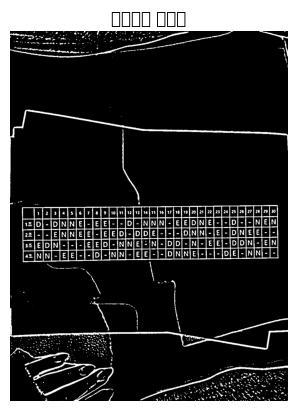

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50808 (\N{HANGUL SYLLABLE OE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44285 (\N{HANGUL SYLLABLE GWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

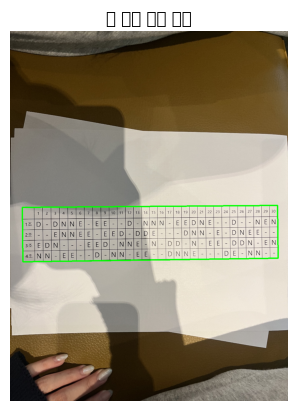

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54632 (\N{HANGUL SYLLABLE HAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


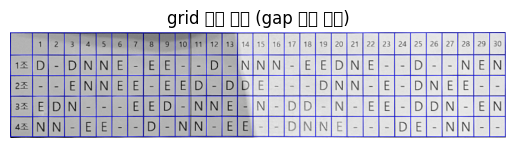

Probabilities: D=0.999, N=0.001, E=0.000 (max=0.999)
Blank cell detected by white_ratio: 0.9638671875
Probabilities: D=1.000, N=0.000, E=0.000 (max=1.000)
Probabilities: D=0.000, N=1.000, E=0.000 (max=1.000)
Probabilities: D=0.000, N=1.000, E=0.000 (max=1.000)
Probabilities: D=0.000, N=0.000, E=1.000 (max=1.000)
Blank cell detected by white_ratio: 0.9501953125
Probabilities: D=0.000, N=0.000, E=1.000 (max=1.000)
Probabilities: D=0.000, N=0.000, E=1.000 (max=1.000)
Probabilities: D=0.037, N=0.903, E=0.060 (max=0.903)
Probabilities: D=0.014, N=0.861, E=0.125 (max=0.861)
Probabilities: D=0.999, N=0.001, E=0.000 (max=0.999)
Probabilities: D=0.080, N=0.516, E=0.404 (max=0.516)
Blank cell detected by prob: 0.51567435
Probabilities: D=0.000, N=1.000, E=0.000 (max=1.000)
Probabilities: D=0.000, N=1.000, E=0.000 (max=1.000)
Probabilities: D=0.000, N=1.000, E=0.000 (max=1.000)
Blank cell detected by white_ratio: 0.982421875
Probabilities: D=0.000, N=0.000, E=1.000 (max=1.000)
Probabilities: D=0.

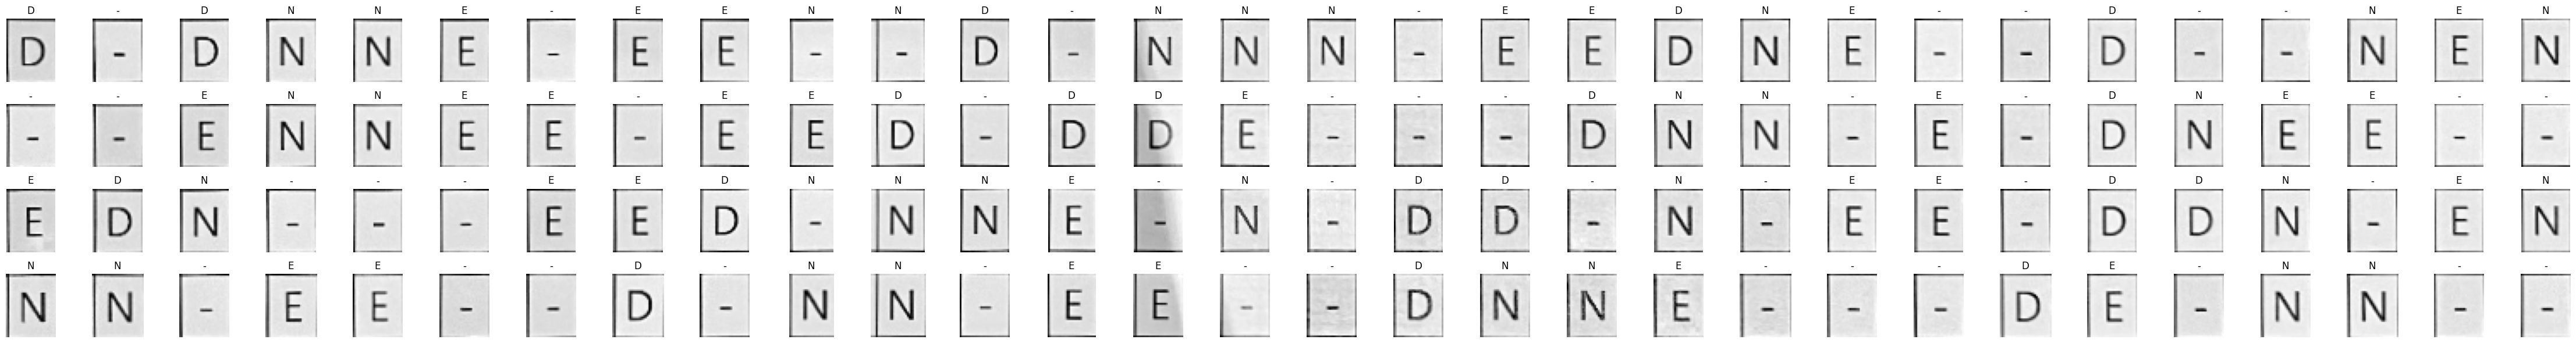

✅ schedule_inferred4.json 저장 완료
{
  "1": {
    "1": "D",
    "2": "-",
    "3": "D",
    "4": "N",
    "5": "N",
    "6": "E",
    "7": "-",
    "8": "E",
    "9": "E",
    "10": "N",
    "11": "N",
    "12": "D",
    "13": "-",
    "14": "N",
    "15": "N",
    "16": "N",
    "17": "-",
    "18": "E",
    "19": "E",
    "20": "D",
    "21": "N",
    "22": "E",
    "23": "-",
    "24": "-",
    "25": "D",
    "26": "-",
    "27": "-",
    "28": "N",
    "29": "E",
    "30": "N"
  },
  "2": {
    "1": "-",
    "2": "-",
    "3": "E",
    "4": "N",
    "5": "N",
    "6": "E",
    "7": "E",
    "8": "-",
    "9": "E",
    "10": "E",
    "11": "D",
    "12": "-",
    "13": "D",
    "14": "D",
    "15": "E",
    "16": "-",
    "17": "-",
    "18": "-",
    "19": "D",
    "20": "N",
    "21": "N",
    "22": "-",
    "23": "E",
    "24": "-",
    "25": "D",
    "26": "N",
    "27": "E",
    "28": "E",
    "29": "-",
    "30": "-"
  },
  "3": {
    "1": "E",
    "2": "D",
    "3": "N",
    "4"

In [ ]:
!pip install opencv-python-headless


# 0. 패키지 임포트 및 설정

import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf

# 사용자 설정
IMAGE_PATH   = "/content/schedule9.jpeg"       # 근무표 이미지 경로
TFLITE_MODEL = "dne_classifier.tflite"      # TFLite 분류기 모델
WHITE_THRESH = 0.92                         # 빈 셀 판단 기준
CLASS_LABELS = ['D', 'N', 'E']              # 분류 클래스
HEADER_SKIP_Y = 1                           # 위쪽 헤더 행 수
HEADER_SKIP_X = 1                           # 왼쪽 헤더 열 수


# 1. 표 검출 및 워핑(정렬)

def detect_and_warp_table(img_path):
    orig_img = cv2.imread(img_path)
    assert orig_img is not None, f"Image not found at {img_path}"
    max_width = 1000
    if orig_img.shape[1] > max_width:
        scale = max_width / orig_img.shape[1]
        orig_img = cv2.resize(orig_img, None, fx=scale, fy=scale)
    gray = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 15, 8)
    plt.imshow(binary, cmap='gray')
    plt.title("이진화된 이미지")
    plt.axis('off')
    plt.show()

    # 외곽 검출
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    table_contour = None
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
        if len(approx) == 4:
            table_contour = approx
            break

    if table_contour is not None:
        def sort_points(pts):
            pts = pts.reshape(4, 2)
            s = pts.sum(axis=1)
            diff = np.diff(pts, axis=1)
            return np.array([
                pts[np.argmin(s)], pts[np.argmin(diff)],
                pts[np.argmax(s)], pts[np.argmax(diff)]
            ], dtype='float32')
        rect = sort_points(table_contour)
        width = int(max(np.linalg.norm(rect[0] - rect[1]), np.linalg.norm(rect[2] - rect[3])))
        height = int(max(np.linalg.norm(rect[0] - rect[3]), np.linalg.norm(rect[1] - rect[2])))
        dst = np.array([[0,0],[width-1,0],[width-1,height-1],[0,height-1]], dtype='float32')
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(orig_img, M, (width, height))
        # 시각화
        temp = orig_img.copy()
        cv2.drawContours(temp, [table_contour], -1, (0, 255, 0), 3)
    else:
        print("표 외곽 인식 실패 — 원본 사용")
        warped = orig_img
        temp = orig_img.copy()

    temp_rgb = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
    plt.imshow(temp_rgb)
    plt.title("표 외곽 검출 결과")
    plt.axis('off')
    plt.show()
    return warped


# 2. robust grid 기반 셀 경계 검출

def get_table_cells(warped, skip_rows=HEADER_SKIP_Y, skip_cols=HEADER_SKIP_X):
    img = warped
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    _, bw = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    h, w = bw.shape
    hor_k = cv2.getStructuringElement(cv2.MORPH_RECT, (max(10, w//30), 1))
    ver_k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, max(10, h//30)))
    hor = cv2.erode(bw, hor_k); hor = cv2.dilate(hor, hor_k)
    ver = cv2.erode(bw, ver_k); ver = cv2.dilate(ver, ver_k)
    grid = cv2.bitwise_and(hor, ver)
    pts = cv2.findNonZero(grid)
    ys = sorted({p[0][1] for p in pts})
    xs = sorted({p[0][0] for p in pts})

    def group(coords, tol=10):
        groups, cur = [], [coords[0]]
        for c in coords[1:]:
            if abs(c-cur[-1]) <= tol:
                cur.append(c)
            else:
                groups.append(cur)
                cur = [c]
        groups.append(cur)
        return [int(sum(g)/len(g)) for g in groups]

    y_lines = group(ys)
    x_lines = group(xs)

    # --- gap 보정 x_lines ---
    x_gaps = np.diff(x_lines)
    mean_gap = np.median(x_gaps)
    new_x = [x_lines[0]]
    for a, b in zip(x_lines, x_lines[1:]):
        gap = b - a
        if gap > mean_gap * 1.5:
            new_x.append(int((a + b) // 2))
        new_x.append(b)
    x_lines = sorted(set(new_x))

    # --- gap 보정 y_lines ---
    y_gaps = np.diff(y_lines)
    mean_gap_y = np.median(y_gaps)
    new_y = [y_lines[0]]
    for a, b in zip(y_lines, y_lines[1:]):
        gap = b - a
        if gap > mean_gap_y * 1.5:
            new_y.append(int((a + b) // 2))
        new_y.append(b)
    y_lines = sorted(set(new_y))

    data_ys = y_lines[skip_rows:]
    data_xs = x_lines[skip_cols:]
    row_ranges = [(data_ys[i],   data_ys[i+1]) for i in range(len(data_ys)-1)]
    col_ranges = [(data_xs[j],   data_xs[j+1]) for j in range(len(data_xs)-1)]

    # grid 시각화 (옵션)
    grid_vis = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    for y in y_lines:
        cv2.line(grid_vis, (x_lines[0], y), (x_lines[-1], y), (0,0,255), 1)
    for x in x_lines:
        cv2.line(grid_vis, (x, y_lines[0]), (x, y_lines[-1]), (0,0,255), 1)
    plt.imshow(grid_vis)
    plt.title("grid 검출 결과 (gap 보정 포함)")
    plt.axis('off')
    plt.show()

    return gray, row_ranges, col_ranges



# 3. tight crop + OCR 분류 함수

def tight_crop_and_resize(cell_img, out_size=(32,32), extra_crop=3):
    if cell_img is None or cell_img.size == 0:
        return np.full(out_size, 255, dtype=np.uint8)
    _, threshed = cv2.threshold(cell_img, 200, 255, cv2.THRESH_BINARY)
    inv = 255 - threshed
    coords = cv2.findNonZero(inv)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        # 더 타이트하게 자르기
        x1 = max(x + extra_crop, 0)
        y1 = max(y + extra_crop, 0)
        x2 = min(x + w - extra_crop, cell_img.shape[1])
        y2 = min(y + h - extra_crop, cell_img.shape[0])
        if x2 > x1 and y2 > y1:
            cropped = cell_img[y1:y2, x1:x2]
        else:
            cropped = cell_img[y:y+h, x:x+w] #잘못 잘라지는 경우, fallback
    else:
        cropped = cell_img
    resized = cv2.resize(cropped, out_size)
    return resized

def classify_dne(cell_img, interpreter, input_details, output_details, debug=False, r=0, c=0):
    tight_img = tight_crop_and_resize(cell_img)
    white_ratio = np.mean(tight_img > 180)
    if debug:
        cv2.imwrite(f'debug_cell_r{r}_c{c}.png', tight_img)
    # 여백 비율로 빈칸 필터링
    if white_ratio > WHITE_THRESH:
        if debug: print("Blank cell detected by white_ratio:", white_ratio)
        return '-' #기준보다 높으면 '-'로 판단
    # 모델 예측
    h, w = input_details[0]['shape'][1:3]
    inp = tight_img.astype(np.float32) / 255.0
    sample = inp.reshape(1, h, w, 1)
    interpreter.set_tensor(input_details[0]['index'], sample)
    interpreter.invoke()
    out = interpreter.get_tensor(output_details[0]['index'])[0]
    max_prob = np.max(out)
    if debug:
        print(f"Probabilities: D={out[0]:.3f}, N={out[1]:.3f}, E={out[2]:.3f} (max={max_prob:.3f})")
    # max 확률이 0.8미만이면 빈칸으로 처리
    if max_prob < 0.8:
        if debug: print("Blank cell detected by prob:", max_prob)
        return '-'
    return CLASS_LABELS[np.argmax(out)]


# 4. 메인 실행 (셀 분할+OCR+시각화)

def main():
    # (1) 표 워핑
    warped = detect_and_warp_table(IMAGE_PATH)
    # (2) robust grid기반 셀 좌표 추출
    gray, data_rows, data_cols = get_table_cells(warped, skip_rows=HEADER_SKIP_Y, skip_cols=HEADER_SKIP_X)
    # (3) 모델 준비
    interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
    interpreter.allocate_tensors()
    input_details  = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    # (4) 셀별 분류 및 저장
    result = {}
    debug_count = 0
    n_rows, n_cols = len(data_rows), len(data_cols)
    plt.figure(figsize=(n_cols*1.5, n_rows*1.5))
    for r, (y1, y2) in enumerate(data_rows):
        row_dict = {}
        for c, (x1, x2) in enumerate(data_cols):
            cell_img = gray[y1:y2, x1:x2]
            debug = (debug_count < 20)
            val = classify_dne(cell_img, interpreter, input_details, output_details,
                               debug=debug, r=r, c=c)
            row_dict[str(c+1)] = val
            if debug: debug_count += 1
            # 셀 시각화
            ax = plt.subplot(n_rows, n_cols, r*n_cols + c + 1)
            plt.imshow(cell_img, cmap='gray')
            plt.title(val)
            plt.axis('off')
        result[str(r+1)] = row_dict
    plt.tight_layout()
    plt.show()

    # (5) 결과 저장
    with open("schedule_inferred.json", "w", encoding="utf-8") as f:
        json.dump(result, f, ensure_ascii=False, indent=2)
    print("schedule_inferred.json 저장 완료")
    print(json.dumps(result, ensure_ascii=False, indent=2))


# 5. 실행

if __name__ == '__main__':
    main()